<a href="https://colab.research.google.com/github/poitrew11/Young-Yandex-homeworks/blob/main/HomeworksCV/Homework2.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import json
import os
import cv2
import random

import numpy as np
import torch
import torchvision
from IPython.display import clear_output
from matplotlib import pyplot as plt
from torchvision.datasets import FashionMNIST

100%|██████████| 26.4M/26.4M [00:01<00:00, 18.2MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 267kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 4.95MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 2.09MB/s]


Text(0.5, 1.0, 'Figure label: 0')

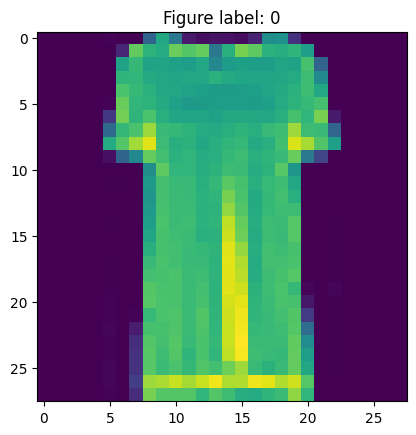

In [ ]:
train_fmnist_data = FashionMNIST('.', train = True, transform = torchvision.transforms.ToTensor(), download = True)
train_data_loader = torch.utils.data.DataLoader(train_fmnist_data, batch_size = 32, shuffle = True, num_workers = 2)

random_batch = next(iter(train_data_loader))
_image, _label = random_batch[0][0], random_batch[1][0]
plt.figure()
plt.imshow(_image.reshape(28, 28))
plt.title(f"Figure label: {_label}")

In [ ]:
import numpy as np

def compute_sobel_gradients_two_loops(image):
  height, width = image.shape
  gradient_x = np.zeros_like(image, dtype = np.float64)
  gradient_y = np.zeros_like(image, dtype = np.float64)

  padded_image = np.pad(image, ((1, 1), (1, 1)), mode = 'constant', constant_values = 0)
  sobel_x = np.array([
      [-1, 0, 1],
      [-2, 0, 2],
      [-1, 0, 1]
  ], dtype = np.float64)
  sobel_y = np.array([
      [-1, -2, -1],
      [0, 0, 0],
      [1, 2, 1]
  ], dtype = np.float64)
  for i in range(1, height + 1):
        for j in range(1, width + 1):
            gradient_x[i-1][j-1] = sum(padded_image[y + i][x + j] * sobel_x[y + 1][x + 1] for y in range(-1, 2) for x in range(-1, 2)) # YOUR CODE HERE
            gradient_y[i-1][j-1] = sum(padded_image[y + i][x + j] * sobel_y[y + 1][x + 1] for y in range(-1, 2) for x in range(-1, 2)) # YOUR CODE HERE

  return gradient_x, gradient_y
def compute_sobel_gradients_opencv(image):
    sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

    return sobel_x, sobel_y

image = train_fmnist_data[7][0][0].numpy()
gradients_two_loops = compute_sobel_gradients_two_loops(image)
gradients_opencv = compute_sobel_gradients_opencv(image)

assert np.allclose(gradients_two_loops[0][1:-1, 1:-1], gradients_opencv[0][1:-1, 1:-1], atol=1e-2), "gradients_two_loops[0] and gradients_opencv[0] are not close"
assert np.allclose(gradients_two_loops[1][1:-1, 1:-1], gradients_opencv[1][1:-1, 1:-1], atol=1e-2), "gradients_two_loops[1] and gradients_opencv[1] are not close"
print("Everything seems fine!")

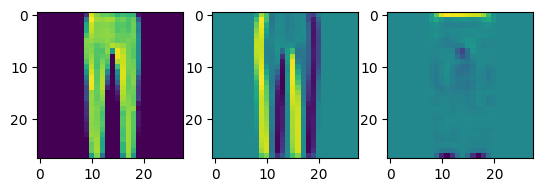

In [ ]:
image = random.choice(train_fmnist_data)[0][0].numpy()
gradients_two_loops = compute_sobel_gradients_two_loops(image)

plt.subplot(1, 3, 1)
plt.imshow(image)
plt.subplot(1, 3, 2)
plt.imshow(gradients_two_loops[0])
plt.subplot(1, 3, 3)
plt.imshow(gradients_two_loops[1])

In [ ]:
def compute_gradient_magnitude(sobel_x, sobel_y):
    '''
    Compute the magnitude of the gradient given the x and y gradients.

    Inputs:
        sobel_x: numpy array of the x gradient.
        sobel_y: numpy array of the y gradient.

    Returns:
        magnitude: numpy array of the same shape as the input [0] with the magnitude of the gradient.
    '''
    magnitude = np.zeros((28, 28))

    for i in range(28):
        for j in range(28):
            magnitude[i][j] = np.sqrt(sobel_x[i][j]**2 + sobel_y[i][j]**2)

    return magnitude

def compute_gradient_direction(sobel_x, sobel_y):
    '''
    Compute the direction of the gradient given the x and y gradients. Angle must be in degrees in the range (-180; 180].
    Use arctan2 function to compute the angle.

    Inputs:
        sobel_x: numpy array of the x gradient.
        sobel_y: numpy array of the y gradient.

    Returns:
        gradient_direction: numpy array of the same shape as the input [0] with the direction of the gradient.
    '''
    gradient_direction = np.zeros((28, 28))

    for i in range(28): # YOUR CODE HERE
        for j in range(28):
            gradient_direction[i][j] = np.degrees(np.arctan2(sobel_y[i][j], sobel_x[i][j]))

    return gradient_direction

In [ ]:
image = train_fmnist_data[7][0][0].numpy()
gradients_two_loops = compute_sobel_gradients_two_loops(image)

magnitudes = compute_gradient_magnitude(gradients_two_loops[0], gradients_two_loops[1])
angles = compute_gradient_direction(gradients_two_loops[0], gradients_two_loops[1])
assert np.all(magnitudes >= 0), "Magnitudes should be non-negative"
assert np.all(angles > -180) and np.all(angles <= 180), "Angles should be in the range (-180, 180]"
print("Everything seems fine!")

Everything seems fine!


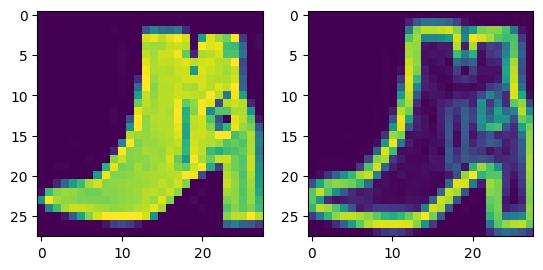

In [ ]:
image = random.choice(train_fmnist_data)[0][0].numpy()
magnitudes = compute_gradient_magnitude(*compute_sobel_gradients_two_loops(image))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.imshow(magnitudes)

In [ ]:
cell_size = 7
def compute_hog(image, pixels_per_cell=(cell_size, cell_size), bins=9):
    # 1. Convert the image to grayscale if it's not already (assuming the image is in RGB or BGR)
    if len(image.shape) == 3:
        image = np.mean(image, axis=2)  # Simple averaging to convert to grayscale

    # 2. Compute gradients with Sobel filter
    gradient_x, gradient_y = compute_sobel_gradients_two_loops(image) # YOUR CODE HERE

    # 3. Compute gradient magnitude and direction
    magnitude = compute_gradient_magnitude(gradient_x, gradient_y) # YOUR CODE HERE
    direction = compute_gradient_direction(gradient_x, gradient_y) # YOUR CODE HERE

    # 4. Create histograms of gradient directions for each cell
    cell_height, cell_width = pixels_per_cell
    n_cells_x = image.shape[1] // cell_width
    n_cells_y = image.shape[0] // cell_height

    histograms = np.zeros((n_cells_y, n_cells_x, bins))
    bin_width = 360.0 / bins

    for i in range(n_cells_y):
        for j in range(n_cells_x):
            # YOUR CODE HERE
            cell_magnitude = magnitude[i * cell_height : (i+1) * cell_height,
                                       j * cell_width  : (j+1) * cell_width]
            cell_direction = direction[i * cell_height : (i+1) * cell_height,
                                       j * cell_width  : (j+1) * cell_width]
            cell_hist = np.zeros(bins)
            for y in range(cell_height):
                for x in range(cell_width):
                    bin_ind = int((cell_direction[y][x] + 180) // bin_width if cell_direction[y][x] + 180 < 360 else bins - 1)
                    cell_hist[bin_ind] += cell_magnitude[y][x]

            if cell_hist.sum() > 0:
                cell_hist /= cell_hist.sum()
            histograms[i, j, :] = cell_hist

    return histograms


In [ ]:
image = random.choice(train_fmnist_data)[0][0].numpy()

hog = compute_hog(image)
assert hog.shape == (4, 4, 9), "hog should have shape (4, 4, 9) for the FashionMNIST image with default parameters"
print("Everything seems fine!")

assert os.path.exists("hog_data.npy") and os.path.exists("image_data.npy"), "hog_data.npy and image_data.npy should be in the same directory as the notebook"
with open("hog_data.npy", "rb") as f:
    hog_data = np.load(f, allow_pickle=True)
with open("image_data.npy", "rb") as f:
    image_data = np.load(f, allow_pickle=True)
for test_image, test_hog in zip(image_data, hog_data):
    hog = compute_hog(test_image)
    assert np.allclose(hog, test_hog), "hog should be the same"

Everything seems fine!


In [ ]:
for idx, (test_image, test_hog) in enumerate(zip(image_data, hog_data)):
    hog = compute_hog(test_image)

    if not np.allclose(hog, test_hog):
        diff = np.abs(hog - test_hog)
        max_diff = np.max(diff)
        print(f"\n❌ Различие найдено в образце {idx}")
        print(f"Максимальная разница: {max_diff:.6f}")

        # Найдём координаты, где расхождение самое большое
        max_coords = np.unravel_index(np.argmax(diff), diff.shape)
        print(f"Максимальное отличие по координатам: {max_coords}")
        print(f"Твое значение: {hog[max_coords]}, Ожидаемое: {test_hog[max_coords]}")
        break
else:
    print("✅ Все хоги совпадают")


✅ Все хоги совпадают


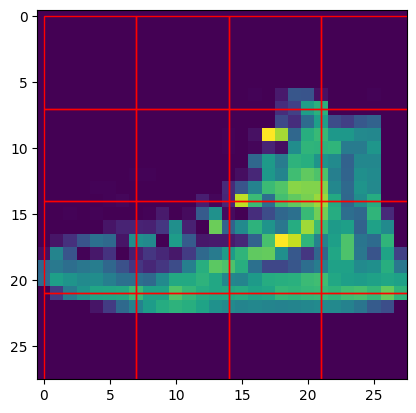

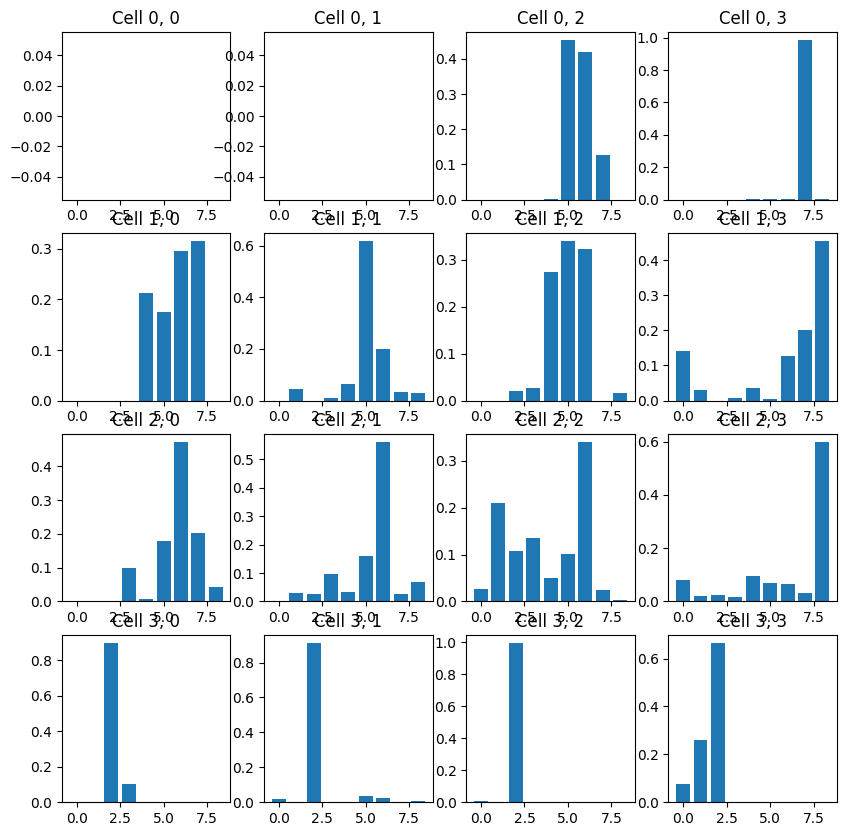

In [ ]:
image = random.choice(train_fmnist_data)[0][0].numpy()
hog = compute_hog(image)

# draw cells on the image
plt.imshow(image)
for i in range(4):
    for j in range(4):
        plt.gca().add_patch(plt.Rectangle((j * cell_size, i * cell_size), cell_size, cell_size, fill=False, edgecolor='red', linewidth=1))
plt.show()


plt.figure(figsize=(10, 10))
for i in range(4):
    for j in range(4):
        plt.subplot(4, 4, i * 4 + j + 1)
        plt.bar(range(len(hog[i, j])), hog[i, j])
        plt.title(f"Cell {i}, {j}")
plt.show()